Trabalho Final da Disciplina de Data Science - CAP 394-2018

    Aluna: Jussara Miranda Dias


Objetivos:

O objetivo deste trabalho é analisar dados de ocorrências de falta de energia elétrica para identificar padrões afim de encontrar uma correlação entre ocorrências e a informação das causas das ocorrências. A idéia do trabalho é identificar se as ocorrências se agrupam por causas climáticas.  


Dados a serem utilizados:

  Foram utilizados para a análise um arquivo .csv  com registros de faltas de energia da região sul do Brasil. Esses dados têm que ter uma confiabilidade em seu cadastro, pois todas as distribuidoras de energia elétrica devem submeter relatórios mensais para o orgão regulador de energia elétrica no Brasil, a ANEEL(Agência Nacional de Energia Elétrica). Então, dados como quantidade de clientes atingidos e duração das interrupções são confiáveis, mas o cadastro das causas das ocorrências fica sob a responsabilidade do eletricista que vai em campo realizar o atendimento das ocorrêcias, desta forma, este cadastro pode não ser confiável. 

Porque realizar este estudo:

  Identificar se o tempo de duração das ocorrências e a quantidade de clientes atingidos tem alguma relação implicita com a causa da ocorrência.

Como os dados estão organizados:

   Foram selecionados 50.000 dados de ocorrências da empresa de distribuição. As imformações mais relavantes a serem consideradas neste trabalho são: quantidade de clientes interrompidos(CI), cliente hora interrompido(CHI), causa, duração da ocorrência, latitude e longitude. Existem 3 hierarquias para identificação e localização das ocorrências, como exemplificado pela figura 1. Neste exemplo, a ocorrência é em um dispositivo de média tensão, nele 2 eventos são identificados e cada evento possui três trechos, que é a chegada da falha em transformadores que alimentam os consumidores. Para identificar a quantidade de clientes atingidos, é necessário percorrer está hierárquia para separar corretamente a quantidade de clientes e o tempo em que cada cliente ficou sem energia.
   
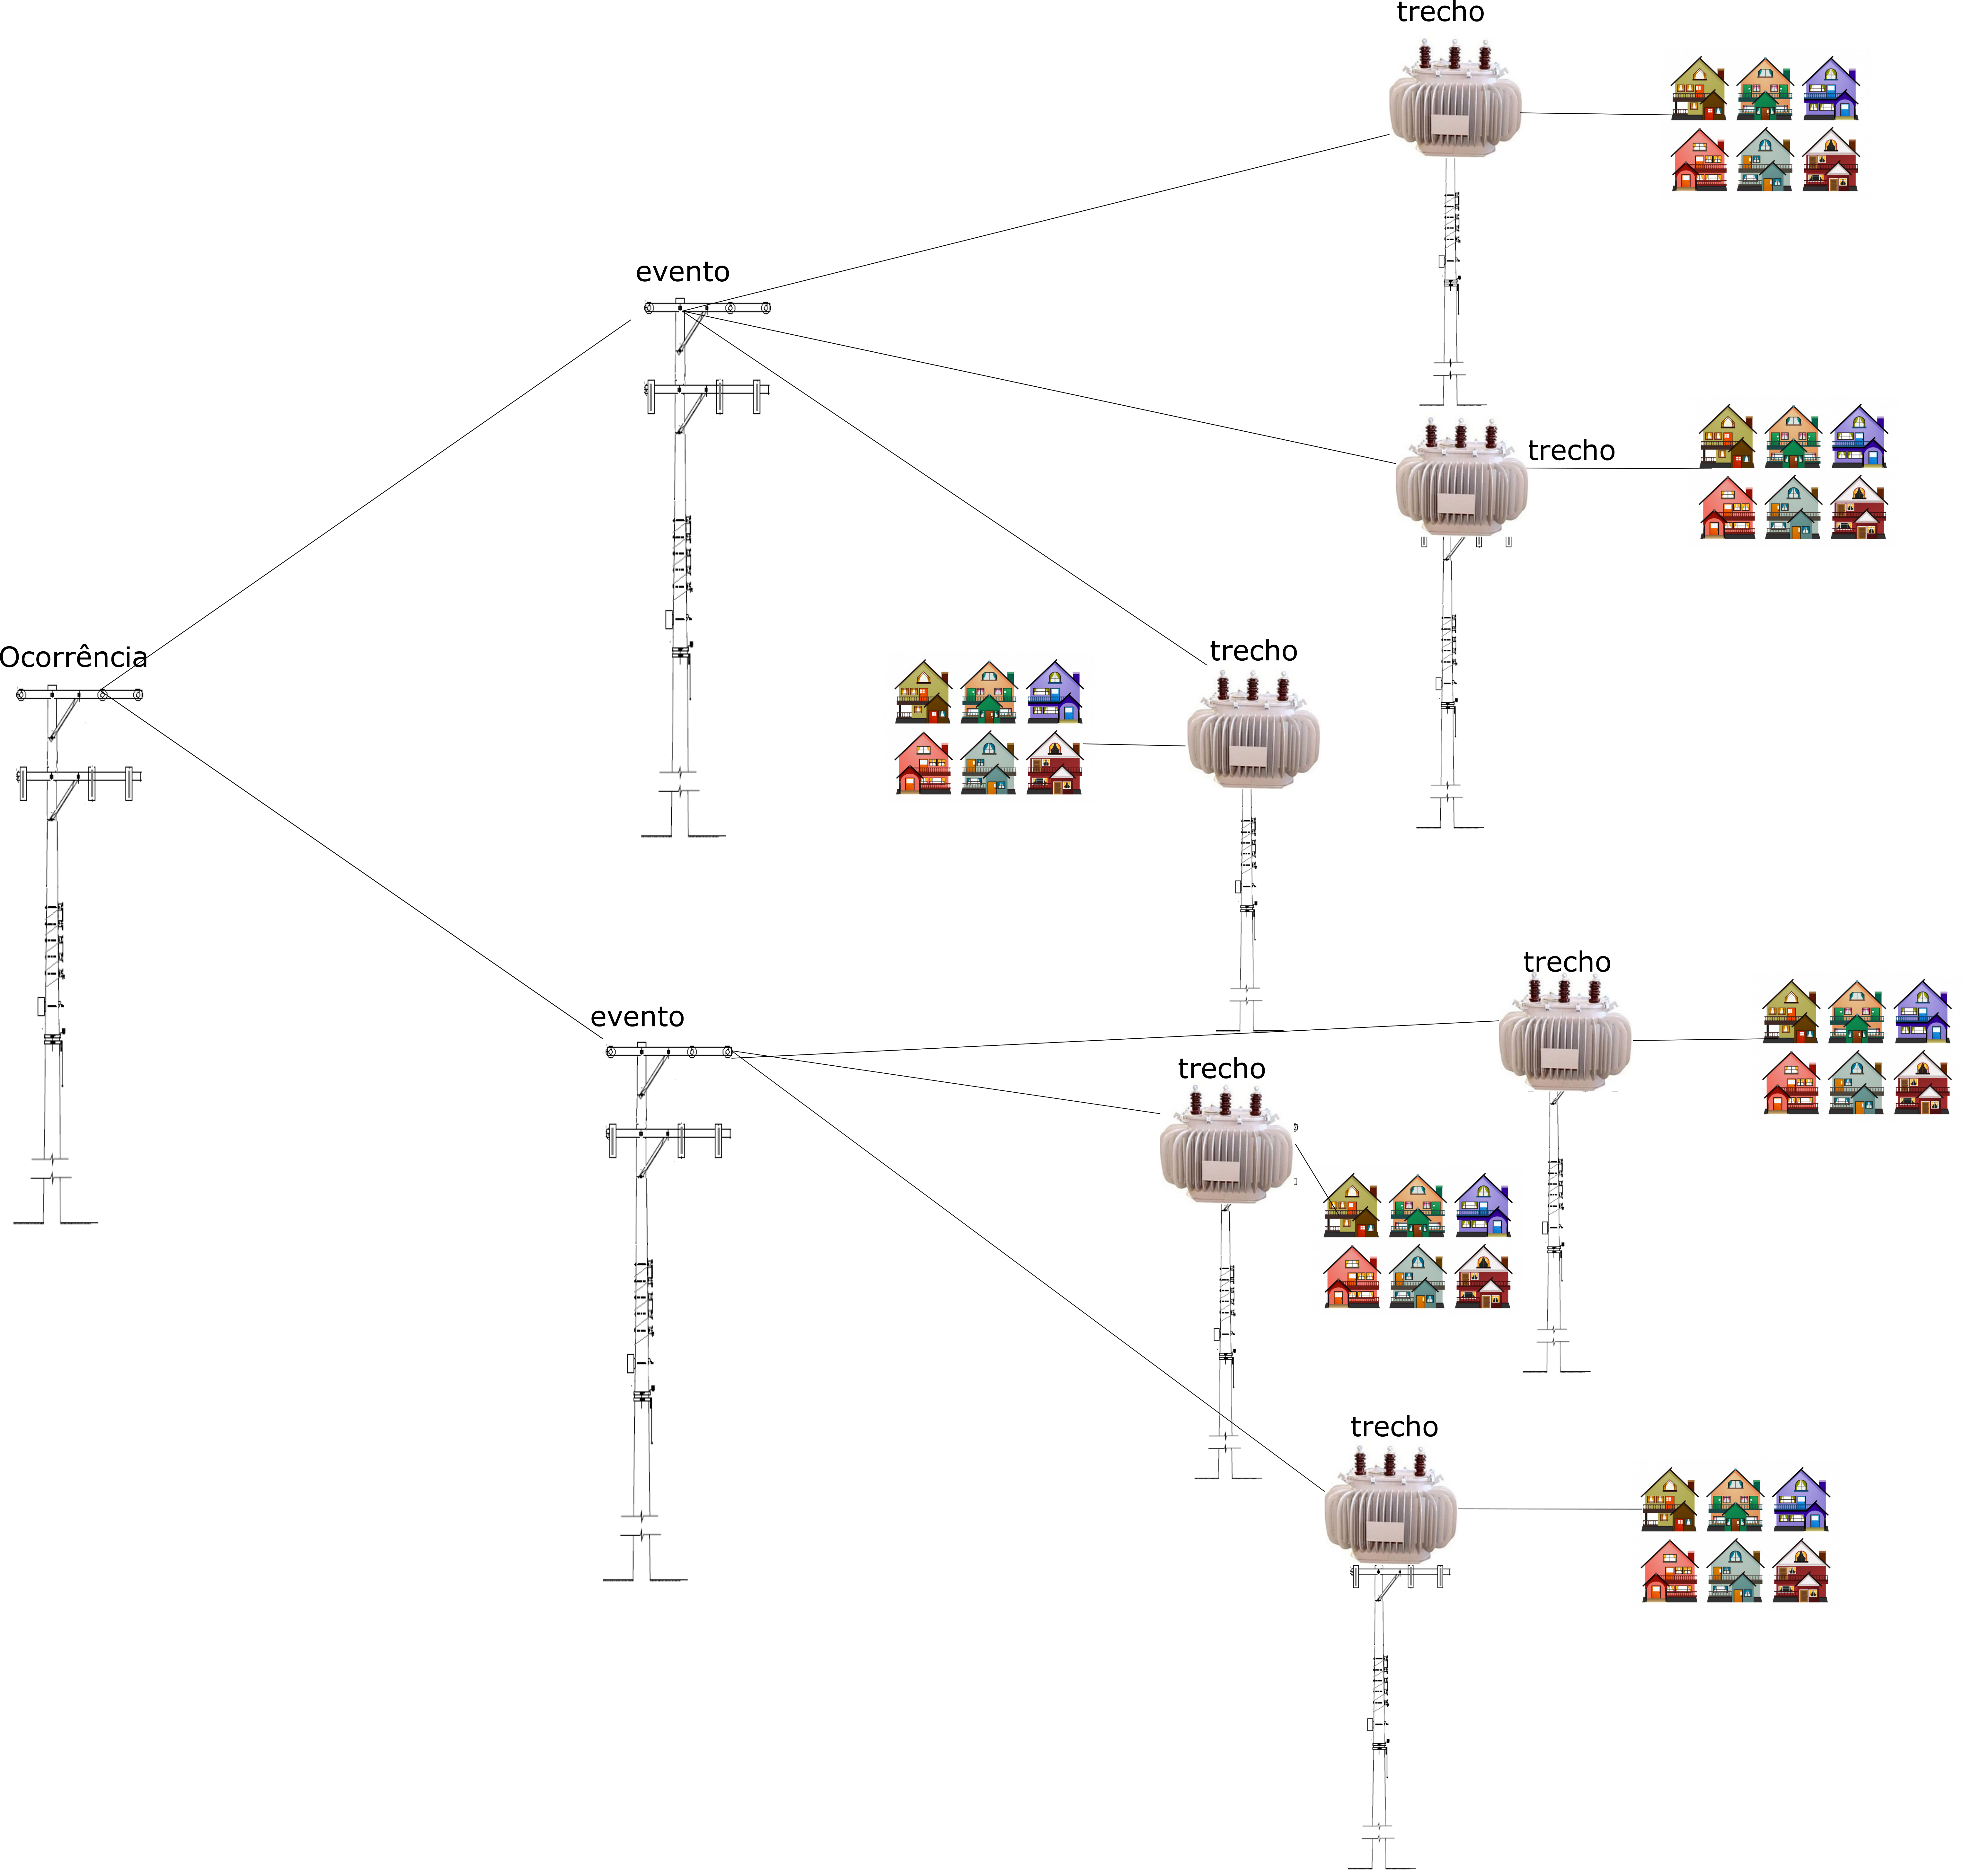
                                      Figura 1: esquema ocorrência/evento/trecho


Neste trabalho será utilizado até o nivel de evento para cálculo de cliente interrompidos e duração da interrupção. A ultilização até nível de trecho é necessário para o cálculo dos índices DEC (Duração Equivalente de Interrupção por Unidade Consumidora) e FEC(Frequência Equivalente de Interrupção por Unidade Consumidora), que não serão calculados para este trabalho. Mas a organização dos dados realizados aqui é um passo para o cálculo destes indicadores.

A análise e tratamento dos dados foram realizados utilizando a linguagem em python, a representação dos dados através de Dataframe da biblioteca pandas. Para a criação dos clusters foi utilizada a biblioteca scikit-learn para o python.

Entrada dos dados: 







In [286]:
#osr:Python GDAL/OGR
import osr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from datetime import datetime
from sklearn import preprocessing
from mpl_toolkits.mplot3d import Axes3D


path_ocorrencia='STG_INSVRGE_DGERAL_OCORRENCIAS_20170920112041.csv'
path_evento='STG_INSVRGE_IND_OCORRENC_EVENT_20170908151113.csv'



In [287]:
def insercaoTabelaOcorrencia(path_ocorrencia):

    # leitura do csv
    df = pd.read_csv(path_ocorrencia, encoding="ISO-8859-1")

    # selecionando as variavies necessárias
    columns1 = ['id_clima', 'id_municipio', 'id_regional', 'id_substacao', 'id_dispositivo',
               'id_ea','id_eacpfl', 'id_empresa', 'id_conjunto', 'id_alimentadores', 'qt_chi', 'qt_ci',
                'id_causa', 'id_area', 'lon', 'lat', 'apura_dia_critico', 'qt_clientes_atingidos',
                'bool_interrupcao', 'dh_inicio', 'dh_interrup', 'dh_despacho', 'dh_chegada_local', 'dh_local_defeito',
                'dh_restabel', 'qt_equipes_atuaram', 'temp_atend', 'temp_preparo', 'temp_deslocamento',
                'temp_localizacao', 'temp_execucao', 'duracao_ocorrencia', 'qt_calls', 'qt_eventos','ds_causa']

    dfMap = pd.DataFrame(columns=columns1)
    
    # Entrada dos dados georreferênciados
    srE = osr.SpatialReference()
    
    # A coordenadas estão na projeção 32722
    srE.ImportFromEPSG(32722)  
    srE.ExportToWkt()

    #Os dados são convertidos para para o projeção 4326
    srS = osr.SpatialReference()  
    srS.ImportFromEPSG(4326)  # wgs utm 21S
    srS.ExportToWkt()

    df['lat1'] = 0.00
    df['lon1'] = 0.00

    #As informações de lat e lon vieram na mesma coluna, elas são separadas em dois campos
    df['lat'], df['lon'] = df['COORDENADAS'].str.split(';', 1).str

    df['lat1']=df['lat']
    df['lon1'] = df['lon']

    # prenechar os valores que possuem nan por zero
    df['lat1']=df['lat1'].fillna('0')
    df['lon1']=df['lon1'].fillna('0')

    # Prencher campos vazios por 0
    df['lon1']=df['lon1'].replace('','0')
    df['lat1'] = df['lat1'].replace('', '0')

    # as coordenadas vieram em cm e devem ser transformadas para metros
    df['lat1'] = df['lat1'].apply(lambda x: int(x) / 100)
    df['lon1'] = df['lon1'].apply(lambda x: int(x) / 100)

    # Mudando a projeção de lat e lon
    ct = osr.CoordinateTransformation(srE, srS)

    df[['lat1', 'lon1', 'xpto']] = pd.DataFrame(
        df.apply(lambda row: ct.TransformPoint(row['lat1'], row['lon1']), axis=1).tolist())
    del df['xpto']

    dfMap['lat'] = df['lon1']
    dfMap['lon'] = df['lat1']

    dfMap['id_clima'] = df['CD_CONDICAO_ATMOSF']
    dfMap['id_clima'].fillna('sem cadastro', inplace=True)

    dfMap['id_ocorrencia'] = df['CD_OCORRENCIA']

  
    dfMap['id_dispositivo'] = df['ID_DISPOSITIVO']
    dfMap['id_dispositivo'].fillna('', inplace=True)

    dfMap['ds_causa'] = df['CD_CAUSA']
    dfMap['ds_causa'].fillna('-', inplace=True)

    dfMap['id_causa'] = df['CD_CAUSA']
    dfMap['id_causa'].fillna('-', inplace=True)

    dfMap['id_ea'] = df['CD_EA']
    dfMap['id_ea'].fillna(0, inplace=True)

    dfMap['id_empresa'] = df['CD_EMPRESA']
    dfMap['id_empresa'].fillna(' ', inplace=True)

    dfMap['id_conjunto'] = df['CD_CONJUNTO']
    dfMap['id_conjunto'].fillna('', inplace=True)

    dfMap['id_alimentadores'] =df['CD_ALIMENTADOR']
    dfMap['id_alimentadores'].fillna('', inplace=True)

    dfMap['id_area'] = df['CD_AREA']
    dfMap['id_area'].fillna('', inplace=True)

    dfMap['qt_chi'] = df['CHAR_QT_CHI']
    dfMap['qt_chi'].fillna(0, inplace=True)
    dfMap['qt_ci'] = df['CHAR_QT_CI']
    dfMap['qt_ci'].fillna(0, inplace=True)

    dfMap['apura_dia_critico'].fillna(0, inplace=True)
    dfMap['qt_clientes_atingidos'].fillna(0, inplace=True)
    dfMap['bool_interrupcao'] = df['FL_INTERRUPCAO']
    dfMap['bool_interrupcao'].fillna('', inplace=True)

    # transformar as datas para %Y%m%d%H%M%S e retirar caracters no meio da data
    conversao = lambda d: str(datetime.strptime(str(int(str(d).replace("ES", "").replace("ED", "").replace("HS", "").replace("HD", "").replace(".0", ""))), '%Y%m%d%H%M%S'))

    dfMap['dh_inicio'] = df['DT_INICIO']
    dfMap['dh_inicio'] = dfMap['dh_inicio'].apply(conversao)

    dfMap['dh_interrup'] = df['DT_INTERRUP']
    dfMap['dh_interrup'].fillna('19701111111111', inplace=True)
    dfMap['dh_interrup'] = dfMap['dh_interrup'].apply(conversao)

    dfMap['dh_despacho'] = df['DT_DESPACHO']
    dfMap['dh_despacho'].fillna('19700101000000', inplace=True)
    dfMap['dh_despacho'] = dfMap['dh_despacho'].apply(conversao)

    dfMap['dh_chegada_local'] = df['DT_CHEGADA_LOCAL']
    dfMap['dh_chegada_local'].fillna('19701111111111', inplace=True)
    dfMap['dh_chegada_local'] = dfMap['dh_chegada_local'].apply(conversao)

    dfMap['dh_local_defeito'] = df['DT_LOCALIZ_DEFEITO']
    dfMap['dh_local_defeito'].fillna('19701111111111', inplace=True)
    dfMap['dh_local_defeito'] = dfMap['dh_local_defeito'].apply(conversao)

    dfMap['dh_restabel'] = df['DT_RESTABEL']
    dfMap['dh_restabel'].fillna('19701111111111', inplace=True)
    dfMap['dh_restabel'] = dfMap['dh_restabel'].apply(conversao)

    dfMap['qt_equipes_atuaram'] = df['QTD_EQUIPES']
    dfMap['qt_equipes_atuaram'].fillna('0', inplace=True)

    dfMap['temp_atend'] = df['CHAR_QT_TA']
    dfMap['temp_atend'].fillna('0', inplace=True)

    dfMap['temp_preparo'] = df['CHAR_QT_TP']
    dfMap['temp_preparo'].fillna('0', inplace=True)

    dfMap['temp_deslocamento'] = df['CHAR_QT_TD']
    dfMap['temp_deslocamento'].fillna('0', inplace=True)

    dfMap['temp_localizacao'] = df['CHAR_QT_TL']
    dfMap['temp_localizacao'].fillna('0', inplace=True)

    dfMap['temp_execucao'] = df['CHAR_QT_TE']
    dfMap['temp_execucao'].fillna('0', inplace=True)

    dfMap['duracao_ocorrencia'] = df['CHAR_QT_DUR_INTERRUP']
    dfMap['duracao_ocorrencia'].fillna('0', inplace=True)

    dfMap['qt_calls'] = df['QT_CALLS']
    dfMap['qt_calls'].fillna(0, inplace=True)

    dfMap['qt_eventos'] = df['QUANT_EVTS_OCOR']
    dfMap['qt_eventos'].fillna(0, inplace=True)

    # salvar resultado em csv
    dfMap.to_csv('ocorrenciasRGE.csv')

    return dfMap

In [288]:
def insercaoTabelaEventos(dfocorrencia,path_evento):

    # dfocorrencia: dataframe com as ocorrencias
    pf=pd.DataFrame(dfocorrencia)
    
    # leitura dos dados de eventos
    df = pd.read_csv(path_evento, encoding="ISO-8859-1")

    # criação das colunas necessárias da tabela evento
    columns1 = ['id_evento','id_ocorrencia','qt_ci','qt_chi','dh_inclusao','dh_ultima_atualilizacao']
    dfMap = pd.DataFrame(columns=columns1)

    dfMap['id_evento']=df['CD_EVENTO']
    dfMap['id_ocorrencia']=df['CD_OCORRENCIA']
    dfMap['qt_ci']=df['QT_CI']
    dfMap['qt_chi'] =df['QT_CHI']

    dfMap['dh_inclusao']=df['DT_INCLUSAO']
    dfMap['dh_ultima_atualilizacao']=df['DT_ULTIMA_ATUALIZACAO']

    # padronizando as datas para %m/%d/%Y %H:%M:%S
    conversaoData = lambda d: str(datetime.strptime(str(d),'%m/%d/%Y %H:%M:%S'))
    dfMap['dh_inclusao'] = dfMap['dh_inclusao'].apply(conversaoData)
    dfMap['dh_ultima_atualilizacao'] = dfMap['dh_ultima_atualilizacao'].apply(conversaoData)

    # o dataframe de ocorrencias e eventos tem em comum o id_ocorrencia, 
    # que é utilizado como uma chave estrangeira em eventos. Para obter as informações em uma só tabela
    # é realizado o merge das tabelas eventos e ocorrecias
    pfMerge=pd.merge(pf, dfMap,how='inner', on=['id_ocorrencia'])

    return pfMerge

In [289]:

def criarConjuntosTreinoTeste(dfeventos,atributos):

    # Agrupar os dados de eventos por id_ocorrencia e somar os valores de CI(cliente interrompido) 
    #e CHI(cliente Hora interrompido)
    
    # se atributos for 0 a qt_eventos faz parte dos atributos de formação do cluster
    # se atributos for 1 a qt_eventos não faz parte dos atributos de formação do cluster
    if(atributos==0):
        agrup=dfeventos.groupby('id_ocorrencia').agg({
            'qt_ci_y': sum,
            'qt_chi_y': sum,
            'qt_eventos': 'first',
            'id_causa': 'first'
        })
    if(atributos==1):
        agrup=dfeventos.groupby('id_ocorrencia').agg({
            'qt_ci_y': sum,
            'qt_chi_y': sum,
            'id_causa': 'first',
            #'qt_eventos': 'first'
        })
    
    # Mapear os códigos de causas para facilitar a identificação das causas.
    agrupamento=agrup
    agrupamento=agrupamento.replace({'id_causa': 'CA05'}, 'arv')
    agrupamento=agrupamento.replace({'id_causa': 'CA15'}, 'raios')
    agrupamento=agrupamento.replace({'id_causa': 'CA22'}, 'erosao')
    agrupamento=agrupamento.replace({'id_causa': 'CA37'}, 'queimada')
    agrupamento=agrupamento.replace({'id_causa': 'CA42'}, 'vento')
    agrupamento=agrupamento.replace({'id_causa': 'CA28'}, 'inundacao')

    # Utilizando replace com expressão regular para susbstituir tudo que for igual a 'CA' por 'outros'
    agrupamento['id_causa'].replace("^CA", "outros", regex=True, inplace=True)

    # Criar um conjunto de teste
    agrupamento_teste=agrup[46000:]

    # Retirar o index
    agrup.reset_index(drop = True, inplace = True)

    # retirar a coluna id_causa, para não fazer parte dos atributos do cluster
    agrup=agrup.drop('id_causa',axis=1)

    # salvando os dados em csv antes de normalizar
    agrup.to_csv('agrupsemNormalizacaoEventos.csv')

    # normalizar os dados para clusterizar
    min_max_scaler = preprocessing.MinMaxScaler()
    np_scaled = min_max_scaler.fit_transform(agrup)
    agrup = pd.DataFrame(np_scaled)

    # salvar os dados após clusterizar
    agrup.to_csv('agrupcomNormalizacao.csv')

    # seperando em dois conjuntos para testar e treinar
    teste=agrup[46000:]
    agrup=agrup[:46000]
    
    return agrup,agrupamento,teste,agrupamento_teste


Com os dados tratados e organizados, agora será utilizado algoritmo de clusterização Kmédias para identicar os agrupamentos por CI, CHI e quantidade de eventos. O algoritmo k–Means ou k–Médias é uma
técnica iterativa muito simples e poderosa para particionar um conjunto de dados em grupos separados, onde o valor de k, deve ser pré–determinado. A distância Euclidiana entre os vetores de atributos xi e os representantes dos clusters é utilizada como medida de dissimilaridade. Na grande maioria dos casos, a melhor quantidade de clusters não é conhecida a priori, então uma técncia pode ser aplicada para identificar um valor de k próximodo valor esperado, esta técnica é o método de Elbow.


O método de Elbow (cotovelo) examina a porcentagem da variação explicada como uma função do número de clusters: deve-se escolher um número de clusters para que a adição de outro cluster não forneça uma modelagem muito melhor dos dados. Mais precisamente, se alguém traça a porcentagem de variância explicada pelos clusters em relação ao número de clusters, os primeiros clusters adicionarão muita informação, mas em algum ponto o ganho marginal cairá, dando um ângulo no gráfico. O número de clusters é escolhido neste ponto, por isso o "método do cotovelo".



In [290]:

# Método Elbow para determinar a melhor quantidade de clusters

def metodoElbow(agrup):
    elbow = []
    print("Valores para k")
    for i in range(1, 10):
        kmeans = KMeans(n_clusters = i, init = 'random')
        kmeans.fit(agrup)
        print (i,kmeans.inertia_)
        elbow.append(kmeans.inertia_)  
    plt.plot(range(1, 10), elbow)
    plt.title('O Metodo Elbow')
    plt.xlabel('Número de Clusters')
    plt.ylabel('kmeans.inertia') #within cluster sum of squares
    plt.show()

In [291]:
# Após aplicar o método de Elbow, verifica-se que o melhor valor de k é 6. 

def kmedias(k,agrup,dim):
    agrup = agrup.values
    kmeans = KMeans(n_clusters = k, init = 'random')
    kmeans.fit(agrup)
    distance = kmeans.fit_transform(agrup)
    C = kmeans.cluster_centers_
    labelsteste = kmeans.predict(teste)

    labels=kmeans.labels_
    fig = plt.figure()
    ax = Axes3D(fig)
    
    if(dim=='3d'):ax.scatter(agrup[:, 0], agrup[:, 1], agrup[:, 2], c=labels,s=100)
    if(dim=='3d'):ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c='#050505', s=200)
    
    if(dim=='2d'):ax.scatter(agrup[:, 0], agrup[:, 1], agrup[:, 1], c=labels,s=100)
    if(dim=='2d'):ax.scatter(C[:, 0], C[:, 1], C[:, 1], marker='*', c='#050505',s=200)
        
    plt.show()
    
    return labelsteste


Valores para k
1 12.88379501169381
2 9.016941790940352
3 6.843452151486499
4 5.618266797652192
5 4.645496423420928
6 4.060828257878217
7 3.1923373583376002
8 2.8609146762537168
9 2.4646720176997934


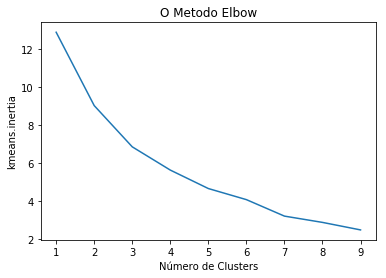

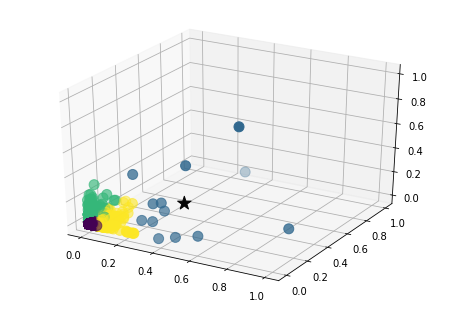

               qt_ci_y  qt_chi_y  qt_eventos id_causa  cluster
id_ocorrencia                                                 
3000083465           0         0           1     CA19        0
3000083469           0         0           1     CA31        0
3000083472           0         0           1     CA11        0
3000083474         196       611           1     CA22        0
3000083475           0         0           1     CA14        0
3000083488           0         0           1     CA14        0
3000083498          13       101           1     CA11        0
3000083500           0         0           1     CA05        0
3000083504           1         1           1     CA05        0
3000083509           1         6           1     CA11        0
3000083512           2         3           1     CA11        0
3000083524           1         0           1     CA42        0
3000083531          10        20           1     CA16        0
3000083536           0         0           1     CA19  

In [292]:
# preencher o dataframe com os dados tratados de ocorrências 
df_ocorrencias=insercaoTabelaOcorrencia(path_ocorrencia)

# preencher o dataframe com os dados tratados de eventos
dfeventos=insercaoTabelaEventos(df_ocorrencias,path_evento)

# criar conjunto com atributos ci,chi e qt_eventos
agrup,agrupamento,teste,agrupamento_teste=criarConjuntosTreinoTeste(dfeventos,0)
metodoElbow(agrup)
labelsteste=kmedias(4,agrup,'3d')

#Resultados:
agrupamento_teste['cluster']=labelsteste
print(agrupamento_teste)

print('Quantidade de instâncias por cluster')
for i in range(0, 5):
   print('cluster('+str(i)+'):',np.shape(agrupamento_teste[agrupamento_teste['cluster']==i]))



Para os Resultados Utilizando 3 atributos (ci,chi e qt_eventos) , mostrados acima, foram obtidos 4 clusters. Com o conjunto de teste utilizado, foi verificado que dos 1013 elementos do conjunto, 4 foram identificados como pertencentes ao cluster 0. Os elementos do cluster 0 possuem os maiores valores de ci e chi. Foram encontradas 6 instâncias para o cluster 3, que foram ocorrências com maiores quantidades de eventos e altos valores de CI e CHi também. Mas não se pode concluir que o cluster 0,1,2 ou 3  somente possuem ocorrências de causas climáticas, mas possuem boas evidências que se estiver no cluster 3, por exemplo, têm um impacto grande no índice DEC, pois possuem os maiores CI e CHIs.

Valores para k
1 8.533647150824244
2 5.784557238716206
3 3.6782836688870666
4 2.7673789638157085
5 2.1946343575254676
6 1.6844871734548736
7 1.241693689511332
8 1.0648850941049504
9 0.9253297302820249


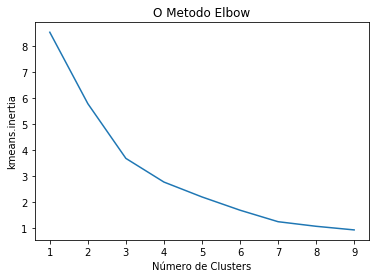

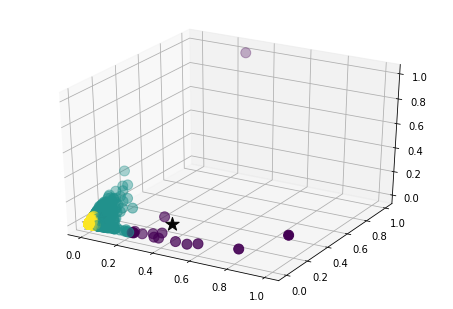

               qt_ci_y  qt_chi_y id_causa  cluster
id_ocorrencia                                     
3000083465           0         0     CA19        2
3000083469           0         0     CA31        2
3000083472           0         0     CA11        2
3000083474         196       611     CA22        2
3000083475           0         0     CA14        2
3000083488           0         0     CA14        2
3000083498          13       101     CA11        2
3000083500           0         0     CA05        2
3000083504           1         1     CA05        2
3000083509           1         6     CA11        2
3000083512           2         3     CA11        2
3000083524           1         0     CA42        2
3000083531          10        20     CA16        2
3000083536           0         0     CA19        2
3000083537         104       512     CA04        2
3000083556           0         0     CA31        2
3000083565           1         4     CA31        2
3000083573          11         

In [293]:
# criar conjunto com atributos ci,chi. Tirando o atributo quantidade de eventos
agrup,agrupamento,teste,agrupamento_teste=criarConjuntosTreinoTeste(dfeventos,1)
metodoElbow(agrup)
labelsteste=kmedias(3,agrup,'2d')

#Resultados:
agrupamento_teste['cluster']=labelsteste
print(agrupamento_teste)

print('Quantidade de instâncias por cluster')
for i in range(0, 4):
   print('cluster('+str(i)+'):',np.shape(agrupamento_teste[agrupamento_teste['cluster']==i]))

Para os Resultados Utilizando 2 atributos (ci,chi) , mostrados acima, 
foram obtidos 3 clusters. Os resulatdos foram semelhantes ao se utilizar 3 tributos.

CONSIDERAÇÕES FINAIS E TRABALHOS FUTUROS:

Os objetivos deste trabalho eram criar clusters utilizando os atributos mais importantes de uma
falha de fornecimento de energia elétrica que são quantidade de clientes atingidos, duração da interrupção e a quantidade de eventos gerados em um desligamento. Verificou-se um grande desbalaenceamento da quantidade de instâncias nos clusters gerados, mas isso a principio já era esperado, pois é grande a quantidade de ocorrências com poucos clientes atingidos e com soemnte 1 evento. Os clusters com  menos quantidade de instâncias indicam, nos dois exemplos utilizados(utilizando 2 e 3 atributos), que as instâncias que se enquadram ali possuem a característica de terem altos CI, CHI e quantidade de enventos. Mas, identificar o cluster por causas climáticas não foi possível, pois os clusters menores possuem também instâncias que não são de causas climáticas.

Para toda a análise desenvolvida neste trabalho,foi necessário realizar um pré-processamento nos dados, pois existiam dados nulos nas colunas, datas e coordenadas em não conformidade.

Basicamente foram utilizadas duas planilhas de dados, a de ocorrências e de eventos. Estas planilhas foram unificadas para obtenção dos valores corretos de CI e CHI.

Como trabalho futuro, utilizarei estes desenvolvimentos para o cálculo do DEC e FEC e analisar o impacto climático nestes índices.  
    
    